In [1]:
import pandas as pd
import yaml
import xgboost
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# +-----------------------------------------------------------------------------

from workers.flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, \
    flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, \
        save_graph, hcluster_graph
from workers.flow import ParallelCreditFlow, GraphExplainer, translator
from workers.flow import group_nodes, build_feature_graph
from workers.flow import CausalLinks, create_xgboost_f, create_linear_f
from workers.flow import edge_credits2edge_credit
from workers.on_manifold import OnManifoldExplainer, IndExplainer, \
    FeatureAttribution
from workers.linear_evaluation import get_error, get_indirect_effect_flow, \
    get_effect_asv, get_effect_ind, get_effect_manifold, get_direct_effect_flow
from workers.linear_evaluation import get_direct_effect_ground_truth, \
    get_indirect_effect_ground_truth

# +-----------------------------------------------------------------------------
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

In [41]:
# +-----------------------------------------------------------------------------
# Загрузка параметров вручную, т.к. у меня эта была другая "тестовая" среда

with open(
    '../ShapFlow//config/config.yaml', \
        'rb') as f:
    cfg = yaml.safe_load(f.read())

X = pd.read_pickle(cfg['PATH_TO_X'])
Y = pd.read_pickle(cfg['PATH_TO_Y'])
RS = cfg['RANDOM_STATE']
OPTUNA_TRIAL_NUMBER = cfg['OPTUNA_TRIAL_NUMBER']
STRATIFY = cfg['STRATIFY']
CLASS_WEIGHT = dict(cfg['CLASS_WEIGHT'])
N_PREDICTORS = cfg['N_PREDICTORS']
BALANCED = cfg['BALANCED']
PATH_TO_OUTPUT = cfg['PATH_TO_OUTPUT']
PATH_TO_PLOT = cfg['PATH_TO_PLOT']
SCORER = cfg['SCORER']
TEST_SIZE = cfg['TEST_SIZE']

# Наши предикторы:

PREDICTORS= [
    'Время ИК', 
    'Hb до операции', 
    'ИМТ', 
    'КДР(исх)', 
    'ФК аортального клапана', 
    'НРС д/о  (1-есть,0-нет)', 
    'Пиковый градиент на АК д/о', 
    'Стеноз -1, недостаточность-0', 
    'Время пережатия аорты', 
    'POAF', 
    'ИБС (Да/Нет - 1/0)', 
    'Возраст, лет', 
    'Перенесенный ИМ (Да/Нет - 1/0)', 
    'ФП д/о', 
    'ППС Порок МК (Да/Нет - 1/0)'
    ]

'/home/guest/Yandex.Disk/GitHub/ShapFlow/ShapFlow'

In [52]:
# Стратифицированный сплит

X_train, X_test, y_train, y_test = \
    train_test_split(
                        X[PREDICTORS], 
                        Y, 
                        test_size=TEST_SIZE, 
                        random_state=RS,
                        stratify=Y
                    )

# +-----------------------------------------------------------------------------
# Вспоминаем, кто из переменных - категориальные  и делаем список с 
# вещественными переменными

cat_lst = [x for x in X[PREDICTORS].columns if \
    pd.CategoricalDtype.is_dtype(X[x])==True]
sc_lst = [col for col in X[PREDICTORS].columns if col not in cat_lst]

# +-----------------------------------------------------------------------------
# Нормализуем вещественные переменные

sc = StandardScaler()

X_train[sc_lst] = sc.fit_transform(X_train[sc_lst])
X_test[sc_lst] = sc.transform(X_test[sc_lst])

# +-----------------------------------------------------------------------------
# У меня не получилось ни обозначить категориальные переменные в XGB, 
# ни заставить это работать через логистическую регрессию также с обозначение 
# категориальных переменных. Везде 0 получаются. Как-то работает через модель 
# LinearRegression
# Т.е., основная цель предыдущего шага с нормализацией в таком контексте - 
# оставить нетронутыми (ненормализованными) бинарные переменные

for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)

for col in X_train.columns:
    X_test[col] = X_test[col].astype(float)

# +-----------------------------------------------------------------------------
# Создание модели из xgboost

xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.01,
    "max_depth": 15,
    'objective':'binary:logistic'
}

model = xgboost.train(
    params, 
    xgb_train, 
    100, 
    evals = [(xgb_train, "train")], 
    verbose_eval=False)

bg = X_train 
fg = X_test

# +-----------------------------------------------------------------------------
# Создание f-функции

f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, 
    columns=feature_names)), output_margin=True)

[09:54:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


learning dependency for POAF:   0%|          | 0/10 [00:00<?, ?it/s]

[0]	test-rmse:0.49958
[100]	test-rmse:0.45698
[200]	test-rmse:0.42480
[300]	test-rmse:0.40158
[400]	test-rmse:0.38531
[499]	test-rmse:0.37373


learning dependency for КДР(исх):  10%|█         | 1/10 [00:17<02:41, 17.94s/it]

[0]	test-rmse:1.15038
[100]	test-rmse:1.11367
[200]	test-rmse:1.08854
[300]	test-rmse:1.07017
[400]	test-rmse:1.05749
[499]	test-rmse:1.05008


learning dependency for ППС Порок МК (Да/Нет - 1/0):  20%|██        | 2/10 [00:29<01:53, 14.20s/it]

[0]	test-rmse:0.49934
[100]	test-rmse:0.44059
[200]	test-rmse:0.39663
[300]	test-rmse:0.36398
[400]	test-rmse:0.34095
[499]	test-rmse:0.32480


learning dependency for Время пережатия аорты:  30%|███       | 3/10 [00:44<01:43, 14.75s/it]      

[0]	test-rmse:1.06394
[100]	test-rmse:0.96309
[200]	test-rmse:0.88954
[300]	test-rmse:0.84203
[400]	test-rmse:0.81211
[499]	test-rmse:0.79302


learning dependency for ФП д/о:  40%|████      | 4/10 [00:52<01:11, 11.91s/it]               

[0]	test-rmse:0.49933
[100]	test-rmse:0.44382
[200]	test-rmse:0.40216
[300]	test-rmse:0.37226
[400]	test-rmse:0.35054
[499]	test-rmse:0.33574


learning dependency for Пиковый градиент на АК д/о:  50%|█████     | 5/10 [00:57<00:47,  9.52s/it]

[0]	test-rmse:1.18016
[100]	test-rmse:1.04514
[200]	test-rmse:0.94294
[300]	test-rmse:0.86748
[400]	test-rmse:0.81279
[499]	test-rmse:0.77365


learning dependency for ФК аортального клапана:  60%|██████    | 6/10 [01:05<00:35,  8.91s/it]    

[0]	test-rmse:1.06549
[100]	test-rmse:0.98633
[200]	test-rmse:0.92764
[300]	test-rmse:0.88427
[400]	test-rmse:0.85292
[499]	test-rmse:0.83120


learning dependency for Время ИК:  70%|███████   | 7/10 [01:10<00:22,  7.59s/it]              

[0]	test-rmse:1.27781
[100]	test-rmse:1.24997
[200]	test-rmse:1.23313
[300]	test-rmse:1.22223
[400]	test-rmse:1.21703
[499]	test-rmse:1.21453


learning dependency for НРС д/о  (1-есть,0-нет):  80%|████████  | 8/10 [01:25<00:19,  9.92s/it]

[0]	test-rmse:0.49984
[100]	test-rmse:0.48444
[200]	test-rmse:0.47466
[300]	test-rmse:0.46836
[400]	test-rmse:0.46452
[499]	test-rmse:0.46257


learning dependency for Перенесенный ИМ (Да/Нет - 1/0):  90%|█████████ | 9/10 [01:34<00:09,  9.68s/it]

[0]	test-rmse:0.49922
[100]	test-rmse:0.42821
[200]	test-rmse:0.37222
[300]	test-rmse:0.32805
[400]	test-rmse:0.29445
[499]	test-rmse:0.26923


learning dependency for Перенесенный ИМ (Да/Нет - 1/0): 100%|██████████| 10/10 [01:47<00:00, 10.71s/it]


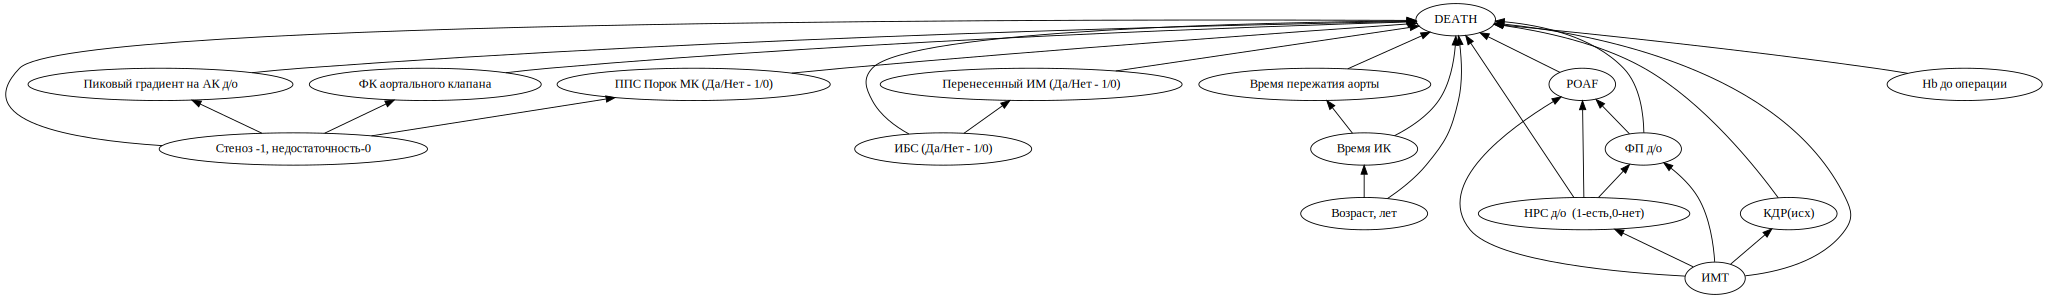

In [53]:
# Создание графа

causal_links = CausalLinks()
target_name = 'DEATH'
feature_names = PREDICTORS

causal_links.add_causes_effects(feature_names, target_name, 
    create_xgboost_f(feature_names, model, output_margin=True))
causal_links.add_causes_effects('Время ИК', 'Время пережатия аорты')
causal_links.add_causes_effects('ИМТ', 'НРС д/о  (1-есть,0-нет)')
causal_links.add_causes_effects('ИМТ', 'ФП д/о')
causal_links.add_causes_effects('ИМТ', 'POAF')
causal_links.add_causes_effects('ИМТ', 'КДР(исх)')
causal_links.add_causes_effects('ИБС (Да/Нет - 1/0)', 
    'Перенесенный ИМ (Да/Нет - 1/0)')
causal_links.add_causes_effects('Стеноз -1, недостаточность-0', \
    'ФК аортального клапана')
causal_links.add_causes_effects('Стеноз -1, недостаточность-0', \
    'Пиковый градиент на АК д/о')
causal_links.add_causes_effects('Стеноз -1, недостаточность-0', \
    'ППС Порок МК (Да/Нет - 1/0)')
causal_links.add_causes_effects('ФП д/о', 'POAF')
causal_links.add_causes_effects('НРС д/о  (1-есть,0-нет)', 'ФП д/о')
causal_links.add_causes_effects('НРС д/о  (1-есть,0-нет)', 'POAF')
causal_links.add_causes_effects('Возраст, лет', 'Время ИК')
causal_links.add_causes_effects('ИМТ', 'КДР(исх)')
causal_graph = build_feature_graph(X_train, causal_links, \
    target_name=target_name, method="xgboost")

causal_graph.draw()


bruteforce sampling: 100%|██████████| 3/3 [00:10<00:00,  3.47s/it]


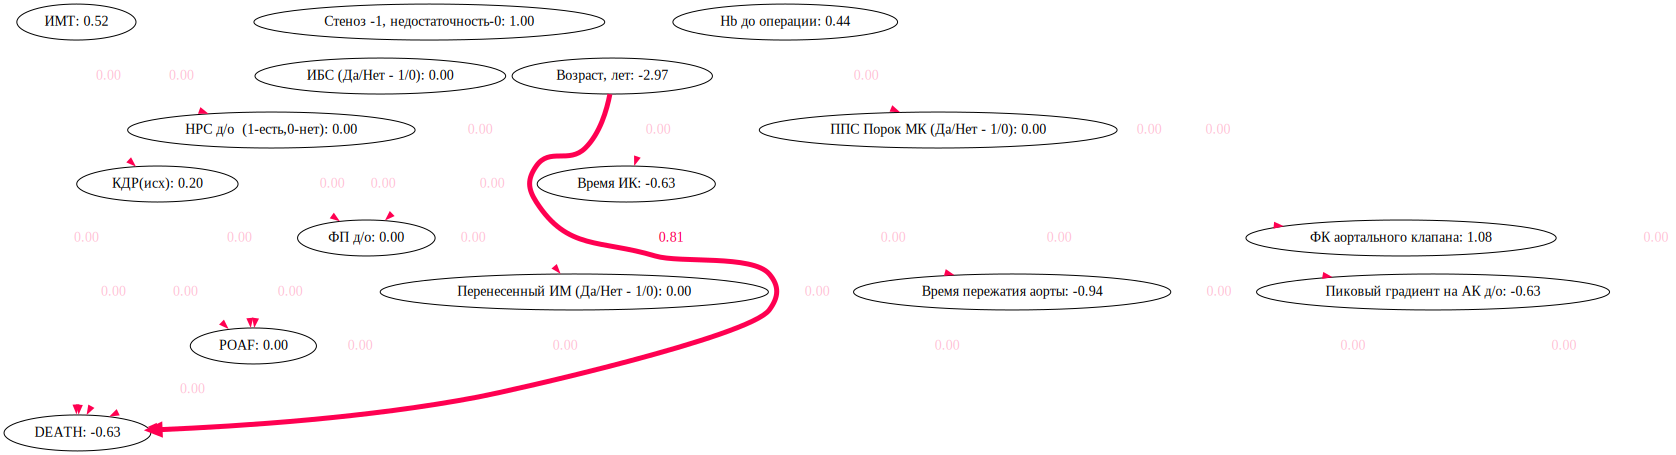

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fc4bc645840>>

In [54]:
# Создание эксплейнера. Во всех примерах со всеми классами (GraphExplainer, 
# on_manifold и т.д.) требуется параметр `sample_ind`, обозначающий отдельное 
# наблюдение/пациента. Для каждого пациента рассматривать эти графы бессмысленно. 
# Ниже я демонстрирую, что будет, если в список `sample_ind` загрузить несколько 
# пациенртов. Теоретически, зависимости меняются и SHAP values становятся ВСЕ 
# синие. 

cf_flow_adult = GraphExplainer(causal_graph, X_train, nruns=3).shap_values(X_train)
sample_ind = [6]

cf_flow_adult.draw(sample_ind, max_display=len(PREDICTORS))

bruteforce sampling: 100%|██████████| 3/3 [00:10<00:00,  3.53s/it]


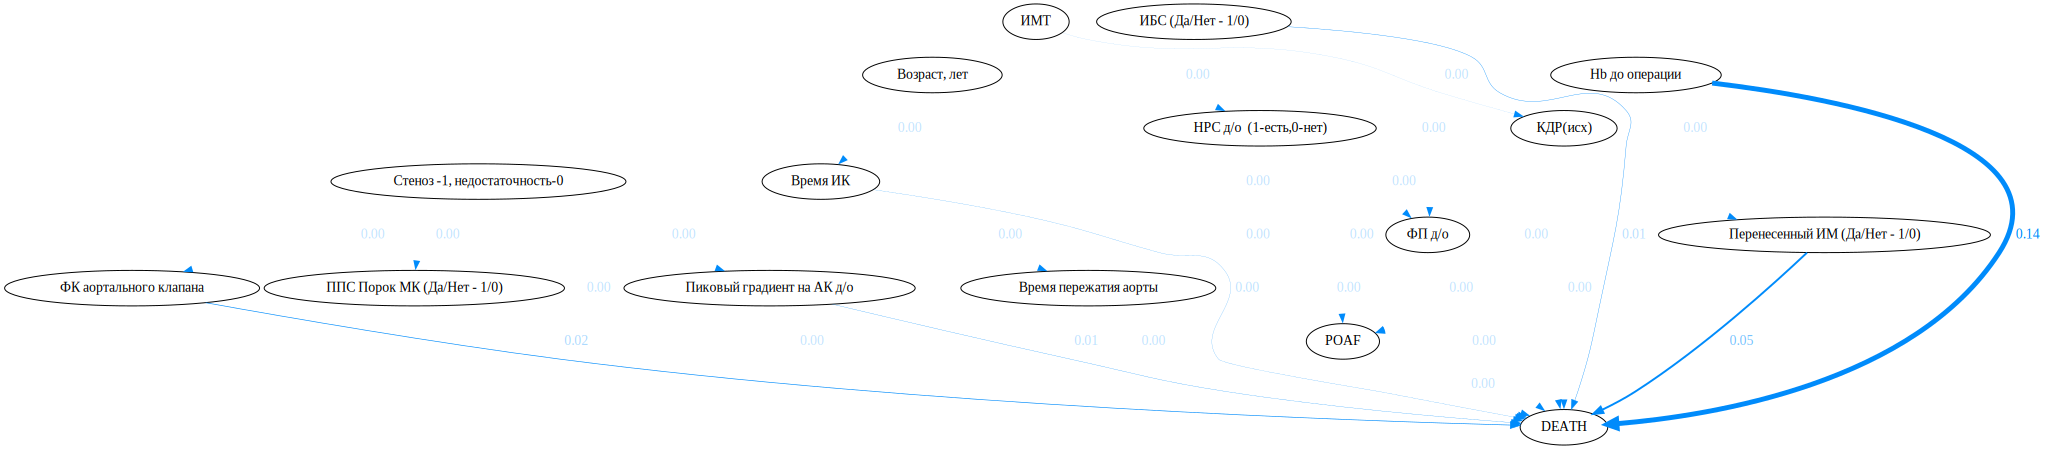

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fc4bc476f60>>

In [55]:
# Да-да, вот тут. Пациенты 1,2,3. 

cf_flow_adult = GraphExplainer(causal_graph, X_train, nruns=3).shap_values(X_train)
sample_ind = [1, 2, 3]

cf_flow_adult.draw(sample_ind, max_display=len(PREDICTORS))